## Final Project Submission

Please fill out:
* Student name: Joe Wilkinson
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# OSEMN
Obtain - Scrub - Explore - Model - Interpret

## Obtain
- Who are the stakeholders in this project? Who will be directly affected by the creation of this project?

**Stakeholders:** Real estate agents, home buyers, home sellers, investors, banks, insurance companies, IRS, real estate development companies

This model is developed for a real estate development company looking to start developing properties in the King Country area. 

- What business problem(s) will this Data Science project solve for the organization?

The model will help the business make decisions about where to buy lots and what to build to maximize their revenue.
*Try to incorporate construction costs to determine ROI 
http://www.nahbclassic.org/generic.aspx?genericContentID=260013/
https://www.fixr.com/costs/build-single-family-house#cQ

- What problems are inside the scope of this project?

This project will determine a model that estimates the sale price of a house and determine which house features have the greatest effect on the sales price.

- What problems are outside the scope of this project?

Determining ROI of each feature is outside the scope of this project. ROI must be determined on an case by case basis using the the architect's project cost estimates in conjunction with this model's price increase estimate.

- What data sources are available to us?

King Count House Sales dataset

In [314]:
#imports and loading in data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline

# KC House Data will be used to build the model for the sales price
df = pd.read_csv('kc_house_data.csv')
# df.head()

*Cost of construction will be estimates based on national construction averages for single family homes adjusted for geographic price differences.*

## Scrub
1. Subsample
2. Dealing with Data Types
3. Dealing with Null Values
4. Check for Multicollinearity
5. Normalize Data
6. One-Hot Encoding

### 1. Subsample
We took a subsample of the data to imporove run times

In [315]:
df = df.sample(frac=0.2, random_state=5)
# df.info()

### 2. Dealing with Datatypes 
- Waterfront and zipcode are categorical variables that were stored floats and ints respectively. 
- Sqft_basement, view and yr_renovated should be ints but couldn't be cast until null values were dealt with

### 3. Dealing with Null Values
We chose to drop all rows that had null values in the view and sqft_basement columns. There was a low number of rows that were missing data.

For yr_renovated, we chose to replace all null and 0 values with the year that the house was built. Obviously, no house was renovated over 2000 years ago, so 0 values shoule equate to the house never having been renovated. Since there was a high number of rows that fit this filter, we couldn't drop the rows. Instead, we elected to replace it with the year th house was built, which is the last year there was major construction done on the house. 

In [316]:
# waterfront, zipcode are categorical data, so I cast them to category
# drop rows with null values
df = df[np.isfinite(df['waterfront'])]
# df.waterfront = df.waterfront.astype('category')
df.zipcode = df.zipcode.astype('category')

# Waterfront is already 1's and 0's, so it just needs to be converted to ints
df.waterfront = df.waterfront.astype('int64')

# Drop any rows where view is NaN, there are a low number of NaN in that column
df = df[np.isfinite(df['view'])]
df.view = df.view.astype('int64')

# sqft_basement should be numerical
# Remove rows with '?' and cast to ints
df = df.loc[df['sqft_basement'] != '?']
df.sqft_basement = df.sqft_basement.astype('float64').astype('int64')

# yr_renovated: if 0.0 or Null, the value should equal the year built since that was the last time it was worked on
mask = ((np.isnan(df['yr_renovated'])) | (df['yr_renovated'] == 0))
column_name = 'yr_renovated'
df.loc[mask, column_name] = df.yr_built
df.yr_renovated = df.yr_renovated.astype('int64')

# Date needs to be converted to a numerical value
df['date'] = pd.to_datetime(df['date'])
df['date'] = (pd.to_datetime('today') - df['date']).dt.days

In [317]:
# Check for any remaining null values
# df.isna().sum()
# df.info()

### 4. Check for Multicollinearity

**Question** *Are there any features that are too highly correlated to be sure how it describes our dependent variable?*

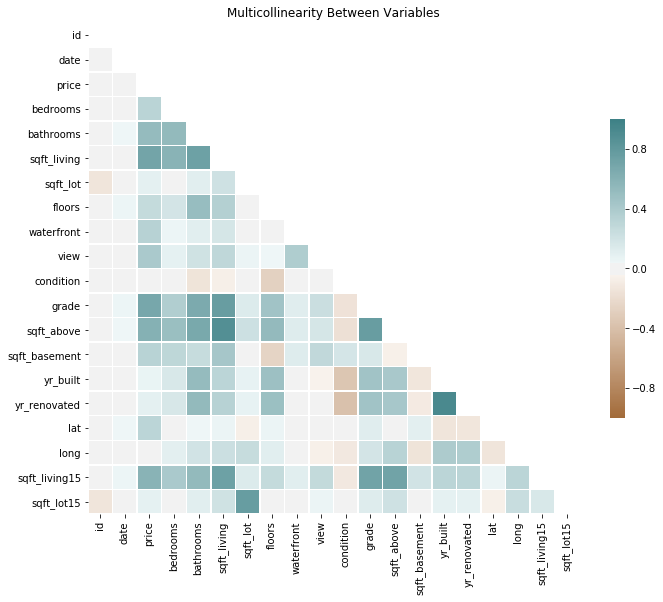

In [318]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(400, 200, as_cmap=True)
ax.set_title('Multicollinearity Between Variables')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [319]:
df.corr()
abs(df.corr()) > 0.75
# Show all pairwise correlations above .75

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
id,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
floors,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


### Results
*Using absolute correlation of >= .75 as the cutoff*

**Columns with high correlation:**
- sqft_living, sqft_above and grade
- sqft_lot and sqft_lot15
- yr_built and year_renovated

We'll drop grade because it is the most subjective of the three. Because sqft_living is sqft_above + sqft_basement and sqft_basement, we're going to drop the sqft_living. This will give us more granularity in our predictors while still eliminating our multicollinearity problem.

This makes sense that a neighborhood would have similar lot sizes. We'll drop sqft_lot15 because it's the column that isn't specifically about the property in question.

This likely is caused by the way I chose to to handle the zeros in the yr_renovated column. Since these columns are highly correlated, we'll drop yr_renovated since it's the transfored column.

Drop ID because it's an aribitrary identification number for a house

**DROP:**
- id
- grade
- sqft_living
- sqft_lot15
- yr_renovated

In [320]:
df.drop(['id', 'grade', 'sqft_living', 'sqft_lot15', 'yr_renovated'], axis=1, inplace=True)
df.describe()

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15
count,3755.000000,3.755000e+03,3755.000000,3755.000000,3.755000e+03,3755.000000,3755.000000,3755.000000,3755.000000,3755.00000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000
mean,1577.112916,5.399681e+05,3.366977,2.130959,1.540888e+04,1.509987,0.005326,0.213316,3.396804,1804.23249,284.206125,1971.766977,47.562675,-122.210337,1981.651931
std,113.381676,3.542885e+05,0.901119,0.773803,4.232521e+04,0.538446,0.072796,0.732482,0.648912,831.99125,442.868912,29.381101,0.138351,0.144104,682.031599
min,1370.000000,8.300000e+04,1.000000,0.750000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,470.00000,0.000000,1900.000000,47.164700,-122.515000,720.000000
25%,1466.000000,3.177500e+05,3.000000,1.750000,5.130000e+03,1.000000,0.000000,0.000000,3.000000,1190.00000,0.000000,1952.000000,47.473100,-122.326000,1490.000000
50%,1589.000000,4.550000e+05,3.000000,2.250000,7.625000e+03,1.500000,0.000000,0.000000,3.000000,1560.00000,0.000000,1977.000000,47.577600,-122.225000,1830.000000
75%,1680.000000,6.500000e+05,4.000000,2.500000,1.065800e+04,2.000000,0.000000,0.000000,4.000000,2260.00000,540.000000,1997.000000,47.680400,-122.121500,2360.000000
max,1757.000000,4.500000e+06,9.000000,7.500000,1.024068e+06,3.500000,1.000000,4.000000,5.000000,7320.00000,3500.000000,2015.000000,47.777600,-121.315000,5790.000000


### 5. Normalize Data
**Question:** *Are all of the features normally distributed?*

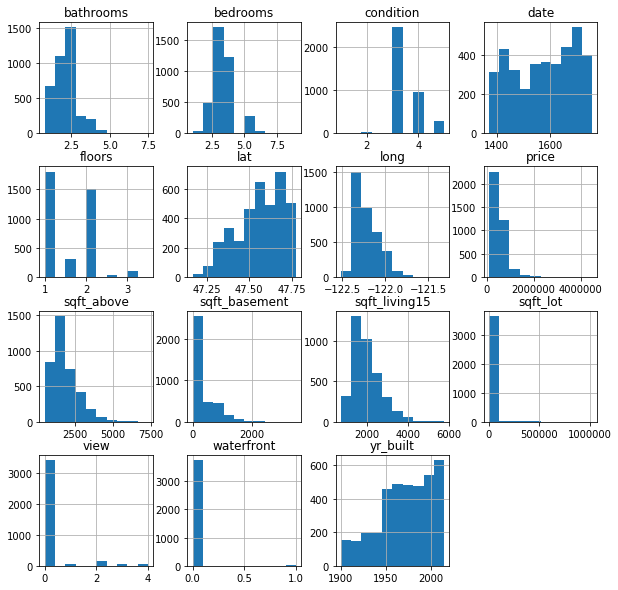

In [321]:
df.hist(figsize=(10,10))
plt.show()

Looks like most of the featrues are skewed. We'll need to log transform all numeric columns. 

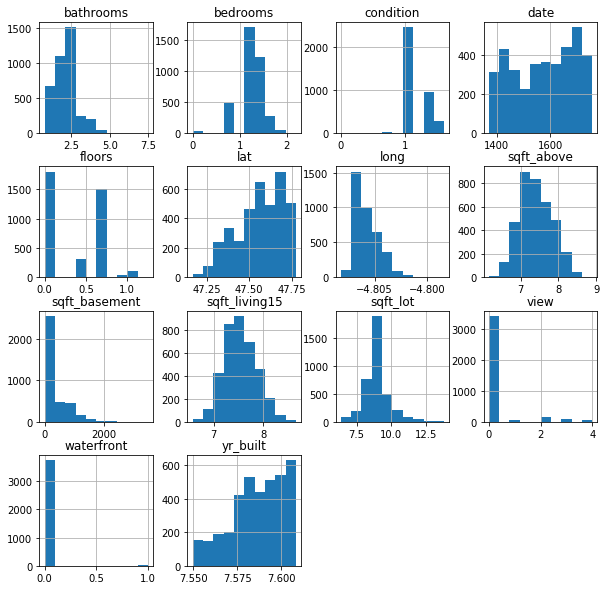

In [322]:
import scipy.stats as stats
ind_vars = df
dep_var = df['price']
ind_vars.drop(['price'], axis=1, inplace=True)
log_transformed = [] # Keep track of which variables were log transformed

for column in df.select_dtypes(include=['int64', 'float64']):
    # We want to log all columns that show signs of skewness
    if stats.skew(df[column]) >= 0.5 or stats.skew(df[column]) <= -0.5:
        """
        Can't log negative numbers. 
        All of of longitudes are negative, so we have to log the absolute value and then multiply by -1.
        """
        if column == 'long':
            ind_vars[column] = np.log(abs(df[column])) 
            ind_vars[column] = df[column] * -1 # Store in our independent variables df
            log_transformed.append(column)
            continue
        elif not df[column].isin([0]).any():
            ind_vars[column] = np.log(df[column]) # Store in our independent variables df
            log_transformed.append(column)
    else:
        ind_vars[column] = df[column] # add any now skewed columns to ind_vars without log

for column in df.select_dtypes(include=['category', 'object']):
    ind_vars[column] = df[column]

ind_vars.hist(figsize=(10,10))
plt.show()

While there is plenty of skewness left in the data, most of the features are looking much more normal. 

In [323]:
# Standardize numeric columns
for column in df.select_dtypes(include=['int64', 'float64']):
    if column != 'price':
        ind_vars[column] = (df[column] - df[column].mean()) / df[column].std()
ind_vars.head()

,date,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15
6035,-0.195031,0.741527,2.415396,0.545758,0.974857,-0.073166,2.439219,-0.584102,2.545379,2.587208,0.957580,98033,0.622510,0.064167,0.486975
12871,-0.247949,0.741527,0.799998,1.277773,0.974857,-0.073166,-0.291223,-0.584102,2.225166,-0.641739,0.823787,98004,0.234367,0.029487,2.210737
21099,-0.415525,0.741527,0.476919,-0.533776,0.974857,-0.073166,-0.291223,-0.584102,0.401484,-0.641739,1.357358,98065,-0.344596,2.349183,1.126219
11629,-1.094647,-1.705584,-0.815399,-0.078602,-0.991727,-0.073166,1.073998,-0.584102,-0.827205,-0.641739,-0.940342,98125,1.207977,-0.525187,0.053576
19536,-0.053914,0.741527,-0.492320,0.174696,-0.991727,-0.073166,-0.291223,0.984322,-0.255983,0.374363,-0.188289,98006,0.040656,0.230647,-0.094412


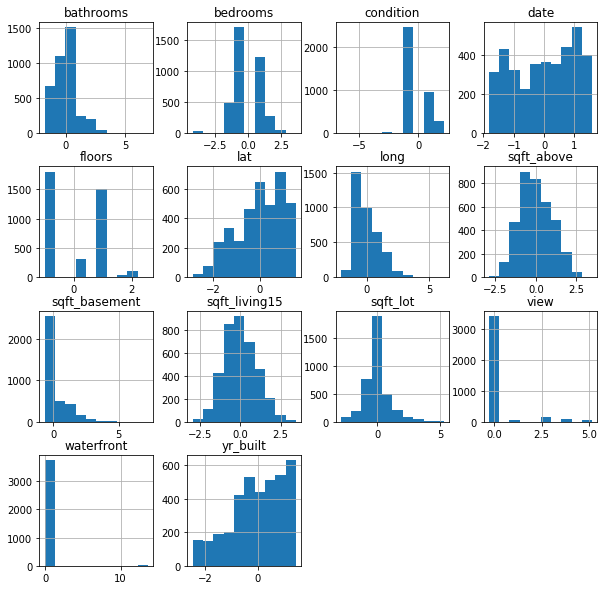

In [324]:
ind_vars.hist(figsize=(10,10))
plt.show()

## Explore
1. Understand the Data
2. Deriving Statistics
3. Creating visualizations

### 1. Understand the Data

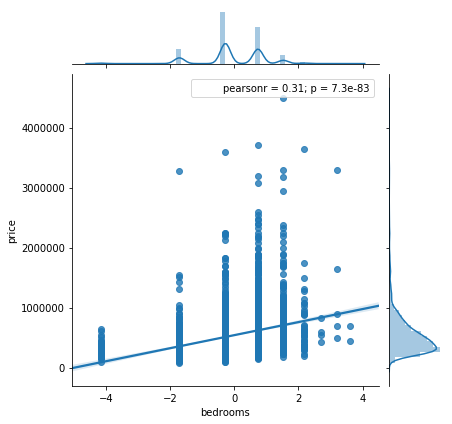

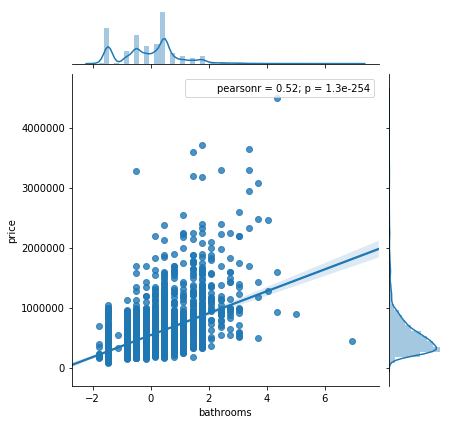

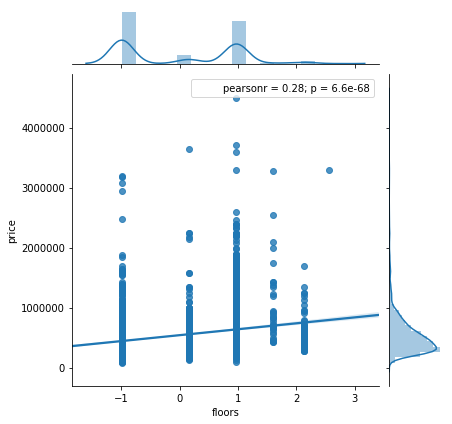

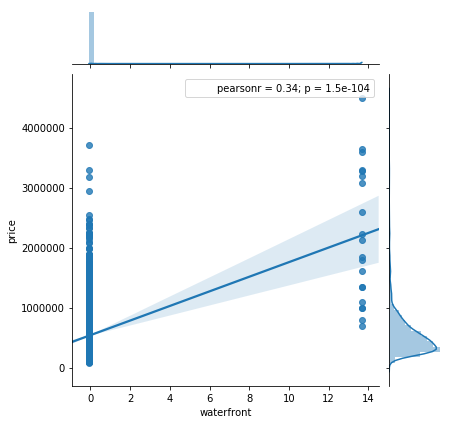

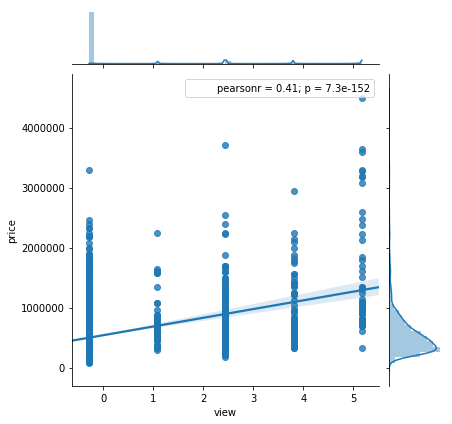

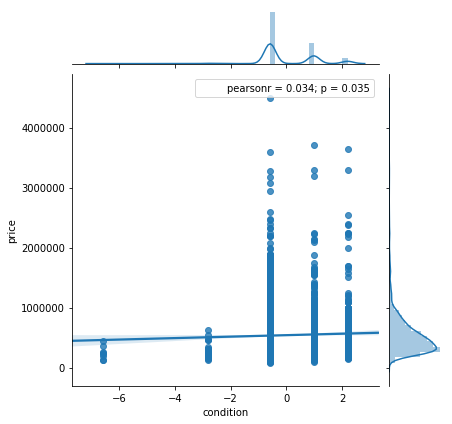

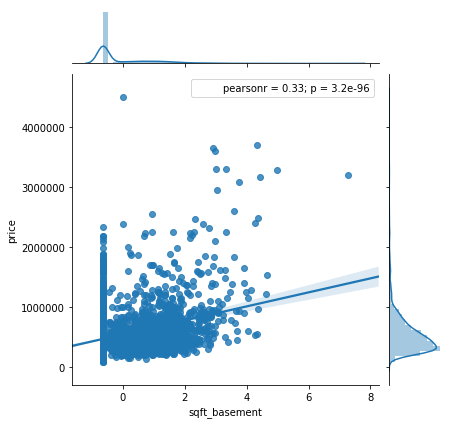

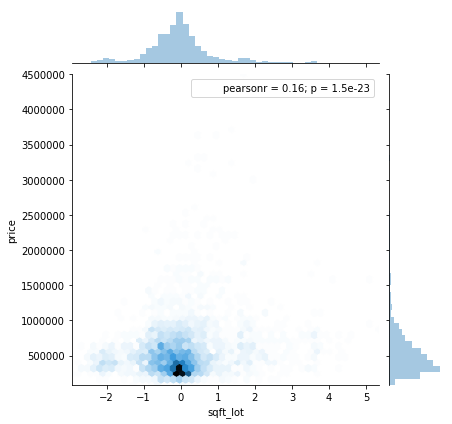

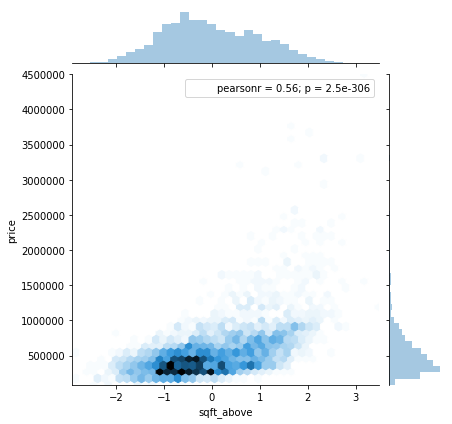

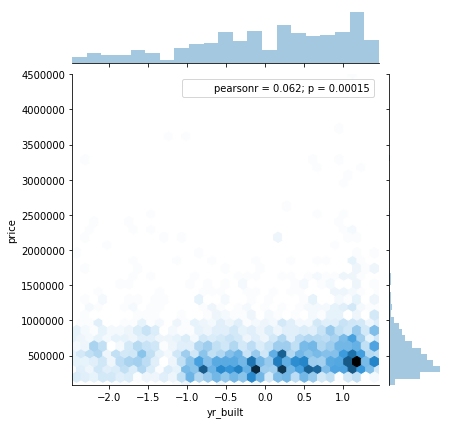

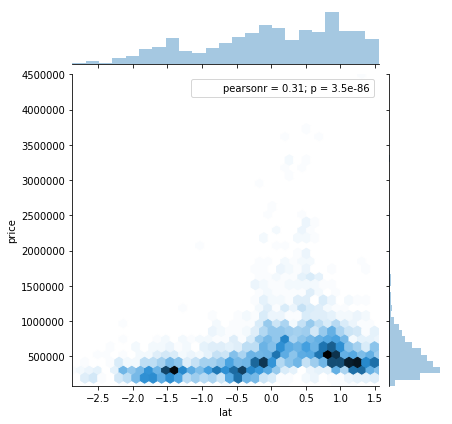

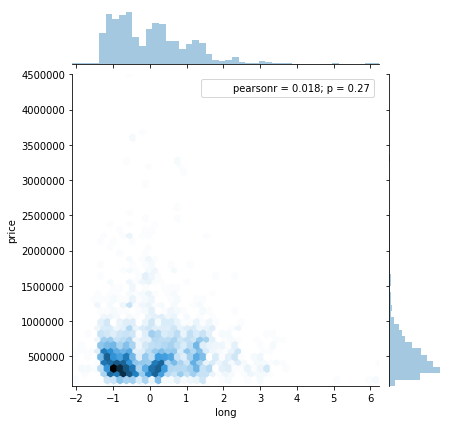

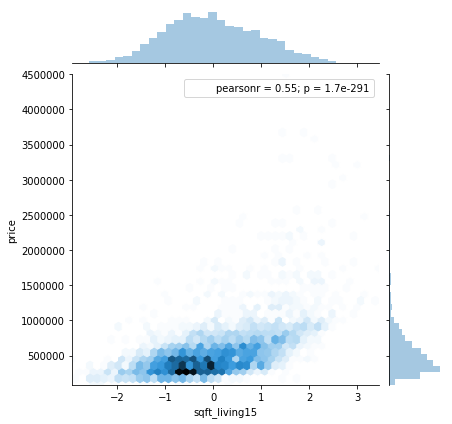

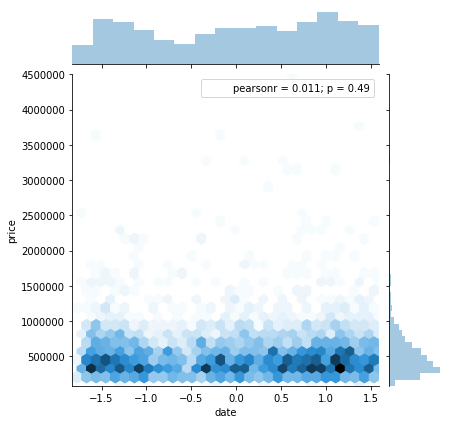

In [325]:
for column in list(ind_vars.select_dtypes(include=['int64', 'float64'])):
    if column not in ['sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
        sns.jointplot(x=ind_vars[column], y=dep_var, kind='reg')
for column in ['sqft_lot', 'sqft_above', 'yr_built', 'lat', 'long', 'sqft_living15', 'date']:
    sns.jointplot(x=ind_vars[column], y=dep_var, kind='hex')

In [326]:
# ind_vars.info()

## 4. Model
1. One - Hot - Encoding
2. Clustering
3. Classification
4. Regression
    - Assess the parameters (slopes, intercept) of the fitted model.
    - Check if the model explain much variation in data? (RMSE, F and R2)
    - Check if the estimates are significant in terms of testing your hypothesis?
    - Interpret the model coefficients, slopes and intercepts using appropriate units?
    - Check the impact of collinearity? Can you ignore it?
5. Dimensionality Reduction


In [327]:
# 1. One Hot Encoding
ind_vars = pd.get_dummies(ind_vars)
# ind_vars.head()
# ind_vars.columns.values
# ind_vars.info()

In [328]:
ind_vars.to_csv('ind_vars_scrubbed.csv')
dep_var.to_csv('dep_var_scrubbed.csv')

In [329]:
X = ind_vars
y = dep_var
y_log = np.log(y)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     175.7
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:06:59   Log-Likelihood:                -50298.
No. Observations:                3755   AIC:                         1.008e+05
Df Residuals:                    3671   BIC:                         1.013e+05
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.396e+05   3309.559    163.031      0.000    5.33e+05    5.46e+05
date          -1.054e+04   2657.749     -3.967      0.000   -1.58e+04   -5333.597
bedrooms      -3.449e+04   3576.262     -9.643      0.000   -4.15e+04   -2.75e+04
bathrooms      2.996e+04   4725.450      6.340      0.000    2.07e+04    3.92e+04
sqft_lot       3.141e+04   4003.715      7.845      0.000    2.36e+04    3.93e+04
floors        -1.033e+04   4380.137     -2.358      0.018   -1.89e+04   -1739.208
waterfront     7.531e+04   2886.015     26.096      0.000    6.97e+04     8.1e+04
view           4.454e+04   3164.309     14.075      0.000    3.83e+04    5.07e+04
condition      1.974e+04   2952.687      6.684      0.000    1.39e+04    2.55e+04
sqft_above     1.603e+05   5814.851     27.561      0.000    1.49e+05    1.72e+05
sqft_basement  5.403e+04   3657.999     14.769      0.000    4.69e+04    6.12e+04
yr_built       -287.5100   4143.877     -0.069      0.945   -8412.038    7837.018
lat            5728.2622   2.14e+04      0.268      0.789   -3.62e+04    4.76e+04
long          -8110.6388   1.39e+04     -0.585      0.558   -3.53e+04     1.9e+04
sqft_living15  2.778e+04   4406.406      6.305      0.000    1.91e+04    3.64e+04
zipcode_98001 -2.252e+05    4.3e+04     -5.241      0.000   -3.09e+05   -1.41e+05
zipcode_98002 -1.658e+05    4.6e+04     -3.602      0.000   -2.56e+05   -7.56e+04
zipcode_98003 -2.068e+05   4.44e+04     -4.656      0.000   -2.94e+05    -1.2e+05
zipcode_98004  6.119e+05   2.35e+04     26.023      0.000    5.66e+05    6.58e+05
zipcode_98005  1.009e+05   3.06e+04      3.301      0.001     4.1e+04    1.61e+05
zipcode_98006  9.757e+04   1.91e+04      5.108      0.000    6.01e+04    1.35e+05
zipcode_98007  5.561e+04   3.56e+04      1.562      0.118   -1.42e+04    1.25e+05
zipcode_98008  7.739e+04   2.77e+04      2.798      0.005    2.32e+04    1.32e+05
zipcode_98010 -1.162e+05   5.25e+04     -2.214      0.027   -2.19e+05   -1.33e+04
zipcode_98011 -1.018e+05   4.12e+04     -2.472      0.013   -1.82e+05   -2.11e+04
zipcode_98014 -1.011e+05   4.97e+04     -2.036      0.042   -1.98e+05   -3722.134
zipcode_98019 -1.635e+05   4.76e+04     -3.435      0.001   -2.57e+05   -7.02e+04
zipcode_98022  -2.26e+05   6.27e+04     -3.607      0.000   -3.49e+05   -1.03e+05
zipcode_98023 -2.314e+05   4.51e+04     -5.135      0.000    -3.2e+05   -1.43e+05
zipcode_98024 -1.779e+04   4.93e+04     -0.361      0.718   -1.14e+05    7.89e+04
zipcode_98027  -4.37e+04    2.6e+04     -1.679      0.093   -9.47e+04    7343.223
zipcode_98028 -1.168e+05   3.95e+04     -2.955      0.003   -1.94e+05   -3.93e+04
zipcode_98029  6.603e+04   2.86e+04      2.306      0.021    9900.190    1.22e+05
zipcode_98030  -2.17e+05    3.7e+04     -5.863      0.000    -2.9e+05   -1.44e+05
zipcode_98031   -1.9e+05   3.24e+04     -5.865   

In [330]:
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     303.7
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:06:59   Log-Likelihood:                 949.33
No. Observations:                3755   AIC:                            -1731.
Df Residuals:                    3671   BIC:                            -1207.
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.8641      0.004   3286.266      0.000      12.856      12.872
date             -0.0248      0.003     -7.895      0.000      -0.031      -0.019
bedrooms         -0.0210      0.004     -4.961      0.000      -0.029      -0.013
bathrooms         0.0317      0.006      5.664      0.000       0.021       0.043
sqft_lot          0.0614      0.005     12.969      0.000       0.052       0.071
floors           -0.0106      0.005     -2.040      0.041      -0.021      -0.000
waterfront        0.0382      0.003     11.183      0.000       0.031       0.045
view              0.0445      0.004     11.902      0.000       0.037       0.052
condition         0.0434      0.003     12.416      0.000       0.037       0.050
sqft_above        0.2307      0.007     33.536      0.000       0.217       0.244
sqft_basement     0.0639      0.004     14.758      0.000       0.055       0.072
yr_built          0.0243      0.005      4.950      0.000       0.015       0.034
lat               0.0451      0.025      1.784      0.075      -0.004       0.095
long             -0.0661      0.016     -4.031      0.000      -0.098      -0.034
sqft_living15     0.0739      0.005     14.179      0.000       0.064       0.084
zipcode_98001    -0.3076      0.051     -6.052      0.000      -0.407      -0.208
zipcode_98002    -0.2615      0.054     -4.803      0.000      -0.368      -0.155
zipcode_98003    -0.2606      0.053     -4.960      0.000      -0.364      -0.158
zipcode_98004     0.8462      0.028     30.429      0.000       0.792       0.901
zipcode_98005     0.4242      0.036     11.728      0.000       0.353       0.495
zipcode_98006     0.3945      0.023     17.464      0.000       0.350       0.439
zipcode_98007     0.3898      0.042      9.258      0.000       0.307       0.472
zipcode_98008     0.3774      0.033     11.537      0.000       0.313       0.442
zipcode_98010     0.0187      0.062      0.302      0.763      -0.103       0.140
zipcode_98011     0.0595      0.049      1.222      0.222      -0.036       0.155
zipcode_98014     0.0850      0.059      1.447      0.148      -0.030       0.200
zipcode_98019    -0.0307      0.056     -0.545      0.586      -0.141       0.080
zipcode_98022    -0.1285      0.074     -1.734      0.083      -0.274       0.017
zipcode_98023    -0.3337      0.053     -6.261      0.000      -0.438      -0.229
zipcode_98024     0.2866      0.058      4.915      0.000       0.172       0.401
zipcode_98027     0.2473      0.031      8.032      0.000       0.187       0.308
zipcode_98028    -0.0264      0.047     -0.564      0.572      -0.118       0.065
zipcode_98029     0.4270      0.034     12.610      0.000       0.361       0.493
zipcode_98030    -0.2663      0.044     -6.084      0.000      -0.352      -0.181
zipcode_98031    -0.1905      0.038     -4.970   

| Dep Var     | price | log_price |
|-------------|-------|-----------|
| R-sq        | 0.799 | 0.873     |
| Adj. R-sq   | 0.794 | 0.870     |
| F-statistic | 175.7 | 303.7     |

- It looks like our log transformed dependent variable allows us to have much more predictive power in our model, so we'll stick with that as our DV.
- drop any continuous variables that have a r-sq < 0.01
- drop one column of any categorical variables

In [331]:
data = X.join(y_log)
for var in ind_vars.select_dtypes(include=['int64', 'float64']):
    formula = 'price~' + var
    print(formula)
    model = smf.ols(formula=formula, data=data)
    reg = model.fit()
    print('r-sq: ', reg.rsquared)
    if reg.rsquared < 0.01:
        X.drop(var, axis=1, inplace=True)
        print('dropped')
    print('-------------------------')

X.drop('zipcode_98199', axis=1, inplace=True)

price~date
r-sq:  0.000105030140257
dropped
-------------------------
price~bedrooms
r-sq:  0.123845966591
-------------------------
price~bathrooms
r-sq:  0.296397866919
-------------------------
price~sqft_lot
r-sq:  0.0209713196113
-------------------------
price~floors
r-sq:  0.110521782948
-------------------------
price~waterfront
r-sq:  0.0386431965868
-------------------------
price~view
r-sq:  0.114549539275
-------------------------
price~condition
r-sq:  0.00092984172643
dropped
-------------------------
price~sqft_above
r-sq:  0.359144079047
-------------------------
price~sqft_basement
r-sq:  0.0926419934024
-------------------------
price~yr_built
r-sq:  0.00849482128386
dropped
-------------------------
price~lat
r-sq:  0.201064102702
-------------------------
price~long
r-sq:  0.0012451311974
dropped
-------------------------
price~sqft_living15
r-sq:  0.35755616179
-------------------------


In [332]:
model = sm.OLS(y_log, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     298.1
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:06:59   Log-Likelihood:                 836.44
No. Observations:                3755   AIC:                            -1513.
Df Residuals:                    3675   BIC:                            -1014.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.4591      0.029    457.063      0.000      13.401      13.517
bedrooms         -0.0194      0.004     -4.491      0.000      -0.028      -0.011
bathrooms         0.0375      0.005      6.931      0.000       0.027       0.048
sqft_lot          0.0563      0.005     11.986      0.000       0.047       0.066
floors           -0.0143      0.005     -2.755      0.006      -0.024      -0.004
waterfront        0.0383      0.004     10.911      0.000       0.031       0.045
view              0.0441      0.004     11.453      0.000       0.037       0.052
sqft_above        0.2322      0.007     32.791      0.000       0.218       0.246
sqft_basement     0.0685      0.004     15.447      0.000       0.060       0.077
lat               0.0554      0.026      2.129      0.033       0.004       0.106
sqft_living15     0.0699      0.005     13.103      0.000       0.059       0.080
zipcode_98001    -0.8495      0.072    -11.809      0.000      -0.991      -0.708
zipcode_98002    -0.8041      0.075    -10.672      0.000      -0.952      -0.656
zipcode_98003    -0.7849      0.073    -10.803      0.000      -0.927      -0.642
zipcode_98004     0.2507      0.037      6.866      0.000       0.179       0.322
zipcode_98005    -0.1757      0.044     -3.997      0.000      -0.262      -0.090
zipcode_98006    -0.2078      0.037     -5.606      0.000      -0.280      -0.135
zipcode_98007    -0.2325      0.049     -4.717      0.000      -0.329      -0.136
zipcode_98008    -0.2419      0.039     -6.175      0.000      -0.319      -0.165
zipcode_98010    -0.6121      0.077     -7.904      0.000      -0.764      -0.460
zipcode_98011    -0.5541      0.046    -12.063      0.000      -0.644      -0.464
zipcode_98014    -0.6767      0.044    -15.390      0.000      -0.763      -0.590
zipcode_98019    -0.7713      0.046    -16.937      0.000      -0.861      -0.682
zipcode_98022    -0.7725      0.092     -8.399      0.000      -0.953      -0.592
zipcode_98023    -0.8266      0.072    -11.499      0.000      -0.968      -0.686
zipcode_98024    -0.4378      0.059     -7.429      0.000      -0.553      -0.322
zipcode_98027    -0.4128      0.042     -9.733      0.000      -0.496      -0.330
zipcode_98028    -0.6132      0.044    -13.996      0.000      -0.699      -0.527
zipcode_98029    -0.2610      0.039     -6.699      0.000      -0.337      -0.185
zipcode_98030    -0.8471      0.065    -13.095      0.000      -0.974      -0.720
zipcode_98031    -0.7635      0.059    -12.968      0.000      -0.879      -0.648
zipcode_98032    -0.8249      0.071    -11.691      0.000      -0.963      -0.687
zipcode_98033    -0.1497      0.035     -4.338      0.000      -0.217      -0.082
zipcode_98034    -0.4313      0.035    -12.388      0.000      -0.500      -0.363
zipcode_98038    -0.6975      0.061    -11.382   

| Dep Var     | price | log_price | w/ removed vars |
|-------------|-------|-----------|-----------------|
| R-sq        | 0.799 | 0.873     | 0.865           |
| Adj. R-sq   | 0.794 | 0.870     | 0.862           |
| F-statistic | 175.7 | 303.7     | 298.1           |

In [333]:
# y_log = pd.DataFrame(y_log)
y = pd.DataFrame(y_log)
y.shape

(3755, 1)

In [334]:
linreg = LinearRegression()
r_sq = []
adj_r_sq = []
y_mean = np.mean(y_log)

for i in range(1, len(X.columns)):
    print(i)
    selector = RFE(linreg, n_features_to_select=i)
    selector = selector.fit(X, np.ravel(y))
    selected_columns = X.columns[selector.support_]
    selector.fit(X[selected_columns], y)
    y_hat = selector.predict(X[selected_columns])
    
    
    # r-sq sum(ye - ym) / sum(y - ym)
    SSR = np.sum((y_hat - y_mean)**2)
    SSTO = np.sum((y - y_mean)**2)
    rsq = SSR / SSTO
    r_sq.append(rsq)
    print(rsq)
    # r-sq adj 1 - (((1 - rsq)(n - 1)) /(n - k - 1))
    rsq_adj = (1 - rsq)*(len(y_log) - 1) / (len(y_log) - X.shape[1] - 1)
    rsq_adj = 1 - rsq_adj
    adj_r_sq.append(rsq_adj)
    print(rsq_adj)
    print('--------------------')



1


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.016756
dtype: float64
price   -0.004654
dtype: float64
--------------------
2


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.071424
dtype: float64
price    0.051204
dtype: float64
--------------------
3


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.104026
dtype: float64
price    0.084517
dtype: float64
--------------------
4


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.121382
dtype: float64
price    0.10225
dtype: float64
--------------------
5


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.139615
dtype: float64
price    0.120881
dtype: float64
--------------------
6


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.148422
dtype: float64
price    0.12988
dtype: float64
--------------------
7


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.167327
dtype: float64
price    0.149196
dtype: float64
--------------------
8


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.184512
dtype: float64
price    0.166755
dtype: float64
--------------------
9


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.198521
dtype: float64
price    0.181069
dtype: float64
--------------------
10


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.212874
dtype: float64
price    0.195735
dtype: float64
--------------------
11


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.237493
dtype: float64
price    0.22089
dtype: float64
--------------------
12


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.246644
dtype: float64
price    0.23024
dtype: float64
--------------------
13


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.259141
dtype: float64
price    0.243009
dtype: float64
--------------------
14


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.272132
dtype: float64
price    0.256283
dtype: float64
--------------------
15


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.296607
dtype: float64
price    0.28129
dtype: float64
--------------------
16


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.308162
dtype: float64
price    0.293097
dtype: float64
--------------------
17


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.311563
dtype: float64
price    0.296573
dtype: float64
--------------------
18


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.323115
dtype: float64
price    0.308376
dtype: float64
--------------------
19


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.327406
dtype: float64
price    0.31276
dtype: float64
--------------------
20


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.337
dtype: float64
price    0.322563
dtype: float64
--------------------
21


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.352022
dtype: float64
price    0.337912
dtype: float64
--------------------
22


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.355609
dtype: float64
price    0.341578
dtype: float64
--------------------
23


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.374673
dtype: float64
price    0.361057
dtype: float64
--------------------
24


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.378523
dtype: float64
price    0.36499
dtype: float64
--------------------
25
price    0.385727
dtype: float64
price    0.372352
dtype: float64
--------------------
26
price    0.389607
dtype: float64
price    0.376316
dtype: float64
--------------------
27


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.392378
dtype: float64
price    0.379147
dtype: float64
--------------------
28


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.39413
dtype: float64
price    0.380938
dtype: float64
--------------------
29


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.397395
dtype: float64
price    0.384273
dtype: float64
--------------------
30
price    0.405676
dtype: float64
price    0.392735
dtype: float64
--------------------
31


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.408694
dtype: float64
price    0.395818
dtype: float64
--------------------
32
price    0.411154
dtype: float64
price    0.398332
dtype: float64
--------------------
33


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.414931
dtype: float64
price    0.402192
dtype: float64
--------------------
34
price    0.416022
dtype: float64
price    0.403306
dtype: float64
--------------------
35


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.722005
dtype: float64
price    0.715951
dtype: float64
--------------------
36
price    0.7263
dtype: float64
price    0.72034
dtype: float64
--------------------
37


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.729789
dtype: float64
price    0.723905
dtype: float64
--------------------
38
price    0.731082
dtype: float64
price    0.725227
dtype: float64
--------------------
39


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.734475
dtype: float64
price    0.728694
dtype: float64
--------------------
40
price    0.736684
dtype: float64
price    0.730951
dtype: float64
--------------------
41


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.741853
dtype: float64
price    0.736232
dtype: float64
--------------------
42
price    0.746648
dtype: float64
price    0.741131
dtype: float64
--------------------
43


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.750313
dtype: float64
price    0.744876
dtype: float64
--------------------
44
price    0.752467
dtype: float64
price    0.747077
dtype: float64
--------------------
45


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.754077
dtype: float64
price    0.748722
dtype: float64
--------------------
46
price    0.757945
dtype: float64
price    0.752675
dtype: float64
--------------------
47


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.760771
dtype: float64
price    0.755561
dtype: float64
--------------------
48
price    0.761417
dtype: float64
price    0.756222
dtype: float64
--------------------
49


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.763783
dtype: float64
price    0.75864
dtype: float64
--------------------
50
price    0.765809
dtype: float64
price    0.76071
dtype: float64
--------------------
51


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.767051
dtype: float64
price    0.761978
dtype: float64
--------------------
52
price    0.76905
dtype: float64
price    0.764021
dtype: float64
--------------------
53


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.771621
dtype: float64
price    0.766648
dtype: float64
--------------------
54
price    0.773838
dtype: float64
price    0.768914
dtype: float64
--------------------
55


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.776935
dtype: float64
price    0.772078
dtype: float64
--------------------
56
price    0.778632
dtype: float64
price    0.773811
dtype: float64
--------------------
57


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.77917
dtype: float64
price    0.774362
dtype: float64
--------------------
58
price    0.826092
dtype: float64
price    0.822305
dtype: float64
--------------------
59


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.826514
dtype: float64
price    0.822736
dtype: float64
--------------------
60
price    0.827007
dtype: float64
price    0.82324
dtype: float64
--------------------
61
price    0.827328
dtype: float64
price    0.823568
dtype: float64
--------------------
62
price    0.827371
dtype: float64
price    0.823612
dtype: float64
--------------------
63
price    0.839029
dtype: float64
price    0.835524
dtype: float64
--------------------
64


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.839322
dtype: float64
price    0.835824
dtype: float64
--------------------
65
price    0.839506
dtype: float64
price    0.836012
dtype: float64
--------------------
66
price    0.851216
dtype: float64
price    0.847977
dtype: float64
--------------------
67


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.851387
dtype: float64
price    0.848151
dtype: float64
--------------------
68
price    0.857682
dtype: float64
price    0.854583
dtype: float64
--------------------
69
price    0.857886
dtype: float64
price    0.854791
dtype: float64
--------------------
70


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


price    0.858006
dtype: float64
price    0.854914
dtype: float64
--------------------
71
price    0.858131
dtype: float64
price    0.855042
dtype: float64
--------------------
72
price    0.858178
dtype: float64
price    0.855089
dtype: float64
--------------------
73
price    0.858258
dtype: float64
price    0.855172
dtype: float64
--------------------
74


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

price    0.862778
dtype: float64
price    0.85979
dtype: float64
--------------------
75
price    0.864042
dtype: float64
price    0.861082
dtype: float64
--------------------
76
price    0.864057
dtype: float64
price    0.861097
dtype: float64
--------------------
77
price    0.864732
dtype: float64
price    0.861787
dtype: float64
--------------------
78
price    0.865011
dtype: float64
price    0.862072
dtype: float64
--------------------
79
price    0.865012
dtype: float64
price    0.862073
dtype: float64
--------------------


/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joe/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

### Train-Test Split

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

for i in range(1, len(X.columns), 5):
    selector = RFE(linreg, n_features_to_select=i)
    selector = selector.fit(X_train, np.ravel(y_train))
    selected_columns = X.columns[selector.support_]
    linreg.fit(X_train[selected_columns], y_train)
    y_hat_train = linreg.predict(X_train[selected_columns])
    
    selector = RFE(linreg, n_features_to_select=i)
    selector = selector.fit(X_test, np.ravel(y_test))
    selected_columns = X.columns[selector.support_]
    linreg.fit(X_test[selected_columns], y_test)
    y_hat_test = linreg.predict(X_test[selected_columns])
    
    mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-y_hat_test)**2)/len(y_test)
    print(i)
    print('Train Mean Squarred Error:', mse_train)
    print('Test Mean Squarred Error:', mse_test)
    print('------------------')

1
Train Mean Squarred Error: price    0.275424
dtype: float64
Test Mean Squarred Error: price    0.264047
dtype: float64
------------------
6
Train Mean Squarred Error: price    0.237748
dtype: float64
Test Mean Squarred Error: price    0.226001
dtype: float64
------------------
11
Train Mean Squarred Error: price    0.21387
dtype: float64
Test Mean Squarred Error: price    0.202727
dtype: float64
------------------
16
Train Mean Squarred Error: price    0.193323
dtype: float64
Test Mean Squarred Error: price    0.18179
dtype: float64
------------------
21
Train Mean Squarred Error: price    0.181489
dtype: float64
Test Mean Squarred Error: price    0.168458
dtype: float64
------------------
26
Train Mean Squarred Error: price    0.169097
dtype: float64
Test Mean Squarred Error: price    0.149425
dtype: float64
------------------
31
Train Mean Squarred Error: price    0.163019
dtype: float64
Test Mean Squarred Error: price    0.144855
dtype: float64
------------------
36
Train Mean Squ

In [336]:
selector = RFE(linreg, n_features_to_select=79)
selector = selector.fit(X, np.ravel(y))
selected_columns = X.columns[selector.support_]

cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")
cv_10

array([-0.04804246, -0.03249288, -0.03917631, -0.03381129, -0.04269151,
       -0.03879721, -0.03921295, -0.03395752, -0.0487324 , -0.03738822])

### Find the best fit
Loop through all possible number of features to include and fit a regression model to it. Then use 10-Fold Cross Validation to insure no overfitting. Store the # of features that best predicts our dependent variable and fit a regression line to it.

In [337]:
best_fit = [0, -100]
for i in range(1, len(X.columns)):
    selector = RFE(linreg, n_features_to_select=i)
    selector = selector.fit(X, np.ravel(y))
    selected_columns = X.columns[selector.support_]
    
    cv_10 = cross_val_score(linreg, X[selected_columns], y, cv=10, scoring="neg_mean_squared_error")
    if (np.mean(cv_10)) > (np.mean(best_fit[1])):
        best_fit = [i, np.mean(cv_10)]
        print(i)
        print(np.mean(cv_10))
        print('------------------')
        

selector = RFE(linreg, n_features_to_select=best_fit[0])
selector = selector.fit(X, np.ravel(y))
selected_columns = X.columns[selector.support_]
X[selected_columns].head()

1
-0.2734226323
------------------
2
-0.258353687575
------------------
3
-0.249452937448
------------------
4
-0.244646962143
------------------
5
-0.239614451859
------------------
6
-0.237246176529
------------------
7
-0.232083074546
------------------
8
-0.227341006887
------------------
9
-0.223557583179
------------------
10
-0.219604419747
------------------
11
-0.212842382776
------------------
12
-0.210388168041
------------------
13
-0.206935850353
------------------
14
-0.203353401933
------------------
15
-0.196618262552
------------------
16
-0.193450030414
------------------
17
-0.192608618573
------------------
18
-0.189512229372
------------------
19
-0.188346946703
------------------
20
-0.185734955741
------------------
21
-0.181734552719
------------------
22
-0.180789152426
------------------
23
-0.17559142787
------------------
24
-0.174582879773
------------------
25
-0.172763803952
------------------
26
-0.171714339161
------------------
27
-0.171294347415
-----

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,lat,sqft_living15,...,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198
6035,0.741527,2.415396,0.545758,0.974857,-0.073166,2.439219,2.545379,2.587208,0.622510,0.486975,...,0,0,0,0,0,0,0,0,0,0
12871,0.741527,0.799998,1.277773,0.974857,-0.073166,-0.291223,2.225166,-0.641739,0.234367,2.210737,...,0,0,0,0,0,0,0,0,0,0
21099,0.741527,0.476919,-0.533776,0.974857,-0.073166,-0.291223,0.401484,-0.641739,-0.344596,1.126219,...,0,0,0,0,0,0,0,0,0,0
11629,-1.705584,-0.815399,-0.078602,-0.991727,-0.073166,1.073998,-0.827205,-0.641739,1.207977,0.053576,...,0,0,0,0,0,0,0,0,0,0
19536,0.741527,-0.492320,0.174696,-0.991727,-0.073166,-0.291223,-0.255983,0.374363,0.040656,-0.094412,...,0,0,0,0,0,0,0,0,0,0


In [338]:
model = sm.OLS(y_log, X[selected_columns]).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1877.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:07:33   Log-Likelihood:                -8013.0
No. Observations:                3755   AIC:                         1.618e+04
Df Residuals:                    3677   BIC:                         1.667e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
bedrooms         -0.0459      0.046     -1.009      0.313      -0.135       0.043
bathrooms         0.0656      0.057      1.151      0.250      -0.046       0.177
sqft_lot         -0.0782      0.049     -1.581      0.114      -0.175       0.019
floors           -0.0569      0.055     -1.038      0.299      -0.164       0.051
waterfront       -0.0553      0.037     -1.493      0.136      -0.128       0.017
view              0.1551      0.040      3.830      0.000       0.076       0.234
sqft_above        0.2121      0.075      2.838      0.005       0.066       0.359
sqft_basement     0.2423      0.047      5.190      0.000       0.151       0.334
lat               6.3547      0.231     27.532      0.000       5.902       6.807
sqft_living15     0.3171      0.056      5.673      0.000       0.207       0.427
zipcode_98001    24.0451      0.491     49.003      0.000      23.083      25.007
zipcode_98002    24.4337      0.542     45.061      0.000      23.371      25.497
zipcode_98003    24.2223      0.499     48.498      0.000      23.243      25.201
zipcode_98004    10.9659      0.290     37.771      0.000      10.397      11.535
zipcode_98005    10.8375      0.384     28.227      0.000      10.085      11.590
zipcode_98006    13.1089      0.230     56.946      0.000      12.658      13.560
zipcode_98007    11.3319      0.447     25.367      0.000      10.456      12.208
zipcode_98008    10.7977      0.325     33.219      0.000      10.160      11.435
zipcode_98010    23.3761      0.596     39.218      0.000      22.207      24.545
zipcode_98011     4.0132      0.474      8.473      0.000       3.085       4.942
zipcode_98014     8.0576      0.420     19.176      0.000       7.234       8.881
zipcode_98019     4.8541      0.464     10.469      0.000       3.945       5.763
zipcode_98022    28.7991      0.684     42.095      0.000      27.458      30.140
zipcode_98023    24.2539      0.482     50.297      0.000      23.308      25.199
zipcode_98024    13.8464      0.526     26.322      0.000      12.815      14.878
zipcode_98027    15.0860      0.262     57.571      0.000      14.572      15.600
zipcode_98028     4.0674      0.450      9.034      0.000       3.185       4.950
zipcode_98029    13.2591      0.266     49.935      0.000      12.739      13.780
zipcode_98030    21.5592      0.440     48.964      0.000      20.696      22.422
zipcode_98031    19.9208      0.393     50.727      0.000      19.151      20.691
zipcode_98032    21.4683      0.536     40.017      0.000      20.416      22.520
zipcode_98033     7.9565      0.312     25.480      0.000       7.344       8.569
zipcode_98034     5.7786      0.340     17.006      0.000       5.112       6.445
zipcode_98038    21.7019      0.381     56.984      0.000      20.955      22.449
zipcode_98039    10.6715      0.608     17.546   

In [339]:
mask = model.pvalues > 0.05


In [340]:
# Remove features with a pvalue < 0.05
columns = model.pvalues[model.pvalues <= 0.05]
columns.index
model = sm.OLS(y_log, X[columns.index]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2004.
Date:                Fri, 22 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:07:38   Log-Likelihood:                -8016.6
No. Observations:                3755   AIC:                         1.618e+04
Df Residuals:                    3682   BIC:                         1.663e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
view              0.1374      0.038      3.635      0.000       0.063       0.211
sqft_above        0.1777      0.051      3.510      0.000       0.078       0.277
sqft_basement     0.2478      0.038      6.456      0.000       0.173       0.323
lat               6.3876      0.230     27.773      0.000       5.937       6.838
sqft_living15     0.3129      0.055      5.643      0.000       0.204       0.422
zipcode_98001    24.0798      0.490     49.146      0.000      23.119      25.040
zipcode_98002    24.4814      0.541     45.250      0.000      23.421      25.542
zipcode_98003    24.2869      0.498     48.773      0.000      23.311      25.263
zipcode_98004    10.9605      0.290     37.854      0.000      10.393      11.528
zipcode_98005    10.8085      0.382     28.288      0.000      10.059      11.558
zipcode_98006    13.1378      0.230     57.188      0.000      12.687      13.588
zipcode_98007    11.3063      0.446     25.338      0.000      10.431      12.181
zipcode_98008    10.7665      0.323     33.304      0.000      10.133      11.400
zipcode_98010    23.3170      0.595     39.199      0.000      22.151      24.483
zipcode_98011     3.9797      0.473      8.415      0.000       3.052       4.907
zipcode_98014     7.9460      0.411     19.344      0.000       7.141       8.751
zipcode_98019     4.7641      0.460     10.365      0.000       3.863       5.665
zipcode_98022    28.8158      0.683     42.211      0.000      27.477      30.154
zipcode_98023    24.3036      0.481     50.512      0.000      23.360      25.247
zipcode_98024    13.7185      0.518     26.507      0.000      12.704      14.733
zipcode_98027    15.0500      0.261     57.602      0.000      14.538      15.562
zipcode_98028     4.0185      0.449      8.948      0.000       3.138       4.899
zipcode_98029    13.2899      0.264     50.350      0.000      12.772      13.807
zipcode_98030    21.5941      0.440     49.087      0.000      20.732      22.457
zipcode_98031    19.9523      0.392     50.847      0.000      19.183      20.722
zipcode_98032    21.4735      0.536     40.083      0.000      20.423      22.524
zipcode_98033     7.9448      0.312     25.480      0.000       7.333       8.556
zipcode_98034     5.7577      0.338     17.013      0.000       5.094       6.421
zipcode_98038    21.7428      0.380     57.157      0.000      20.997      22.489
zipcode_98039    10.6946      0.608     17.597      0.000       9.503      11.886
zipcode_98042    21.8042      0.389     56.062      0.000      21.042      22.567
zipcode_98045    17.0858      0.359     47.540      0.000      16.381      17.790
zipcode_98052     7.5782      0.287     26.359      0.000       7.015       8.142
zipcode_98053     7.6375      0.332     22.984      0.000       6.986       8.289
zipcode_98055    17.5063      0.343     50.972   

In [265]:
log_transformed

['bedrooms',
 'sqft_lot',
 'floors',
 'condition',
 'sqft_above',
 'yr_built',
 'long',
 'sqft_living15']